In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import polars as pl
import numpy as np
import matplotlib.pyplot as plt



In [53]:
# create data
# this data was taken from one of my udemy courses that I attended to learn pytorch
# I rewrote the whole script in polars and tailor it for my own learnings
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# Generate data using Polars
# Create DataFrames for each cluster
a_df = pl.DataFrame({
    'x': A[0] + np.random.randn(nPerClust) * blur,
    'y': A[1] + np.random.randn(nPerClust) * blur,
    'label': [0] * nPerClust
})

b_df = pl.DataFrame({
    'x': B[0] + np.random.randn(nPerClust) * blur,
    'y': B[1] + np.random.randn(nPerClust) * blur,
    'label': [1] * nPerClust
})

c_df = pl.DataFrame({
    'x': C[0] + np.random.randn(nPerClust) * blur,
    'y': C[1] + np.random.randn(nPerClust) * blur,
    'label': [2] * nPerClust
})

# Concatenate into a single DataFrame
all_data = pl.concat([a_df, b_df, c_df])


In [54]:
print(all_data)

shape: (900, 3)
┌──────────┬──────────┬───────┐
│ x        ┆ y        ┆ label │
│ ---      ┆ ---      ┆ ---   │
│ f64      ┆ f64      ┆ i64   │
╞══════════╪══════════╪═══════╡
│ 1.89966  ┆ 1.079582 ┆ 0     │
│ 2.411828 ┆ 0.527253 ┆ 0     │
│ 0.818397 ┆ 1.764386 ┆ 0     │
│ 2.123029 ┆ 0.605125 ┆ 0     │
│ 2.818537 ┆ 1.937929 ┆ 0     │
│ …        ┆ …        ┆ …     │
│ 2.529382 ┆ 6.387052 ┆ 2     │
│ 3.250226 ┆ 1.842166 ┆ 2     │
│ 3.790451 ┆ 4.358876 ┆ 2     │
│ 5.666034 ┆ 4.220886 ┆ 2     │
│ 5.931247 ┆ 3.331688 ┆ 2     │
└──────────┴──────────┴───────┘


In [55]:
##

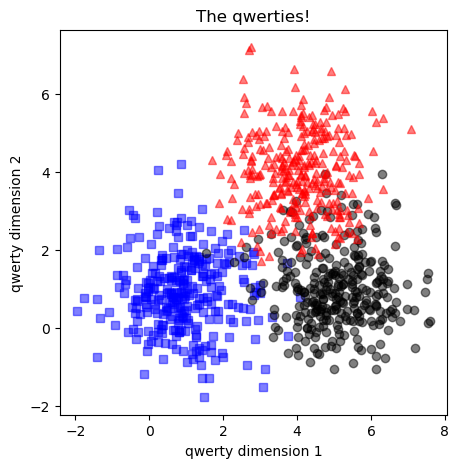

In [56]:
# Convert to PyTorch tensors
data = torch.tensor(all_data.select(['x', 'y']).to_numpy()).float()
labels = torch.tensor(all_data['label'].to_numpy()).long()  # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[labels == 0, 0], data[labels == 0, 1], 'bs', alpha=.5)
plt.plot(data[labels == 1, 0], data[labels == 1, 1], 'ko', alpha=.5)
plt.plot(data[labels == 2, 0], data[labels == 2, 1], 'r^', alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [57]:
# scikitlearn to split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)


In [58]:
# convert them to pytorch dataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [59]:
# this is accessing the X_train
print((train_data.tensors[0].shape))
print((test_data.tensors[0].shape))

torch.Size([720, 2])
torch.Size([180, 2])


In [60]:
# translate it into dataloader
batchSize = 16

train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# check how many batches are there
print(f'There are {len(train_loader)} batches, each with {batchSize}.')
print(f'There are {len(test_loader)} batches, in test_loader.')


There are 45 batches, each with 16.
There are 1 batches, in test_loader.


## Create the model class

In [61]:
## create a class fopr the model
class ANNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        # create the input layer
        self.input =nn.Linear(2, 8)
        # create hidden layers
        self.hidden1 = nn.Linear(8, 8)
        # create the output layer
        self.output = nn.Linear(8, 3)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        return self.output(x)


## Create a function to train the model

In [62]:
def trainModel(model, train_loader, test_loader, numepochs=100, learning_rate=0.01):
    # define an empty dataframe
    training_progess = pl.DataFrame(
        schema={
            'iteration' : pl.Int64,
            'epoch' : pl.Int64,
            'batch_train_loss' : pl.Float64,
            'batch_test_loss' : pl.Float64,
            'batch_train_acc' : pl.Float64,
            'batch_test_acc' : pl.Float64,

        }
    )

    # create the optimizer and loss function
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    iteration = 0

    # loop through epochs
    for epoch in range(numepochs):
        model.train()
        for X, y in train_loader:
            # loop through the batches
            yHat = model(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the accuracy
            matches = torch.argmax(yHat, axis=1) == y # boolean (True or False)
            matchesNumeric = matches.float()
            train_acc = 100 * torch.mean(matchesNumeric) # get the average and convert to percentage

            # switch to evaluation
            X_test, y_test = next(iter(test_loader))
            with torch.no_grad():
                yHat_test = model(X_test)
                loss_test = lossfunc(yHat_test, y_test)

            test_acc = 100 * torch.mean((torch.argmax(yHat_test, axis=1) == y_test).float()).item()

            # switch back to training
            model.train()

            # add the the values into a row and concatenate with the dataframe
            new_row = pl.DataFrame([{
                'iteration' : iteration,
                'epoch' : epoch,
                'batch_train_loss' : loss.item(),
                'batch_test_loss' : loss_test.item(),
                'batch_train_acc' : train_acc.item(),
                'batch_test_acc' : test_acc,
            }])

            training_progess = pl.concat([training_progess, new_row])
            # move the iteration up at the end of this loop
            iteration += 1

    return training_progess


## train the model

In [63]:
# create the model
model = ANNmodel()

# train the model
training_progress = trainModel(model, train_loader=train_loader, test_loader=test_loader, learning_rate=0.01, numepochs=200)

In [64]:
# inspect the data
print(training_progress)

shape: (9_000, 6)
┌───────────┬───────┬──────────────────┬─────────────────┬─────────────────┬────────────────┐
│ iteration ┆ epoch ┆ batch_train_loss ┆ batch_test_loss ┆ batch_train_acc ┆ batch_test_acc │
│ ---       ┆ ---   ┆ ---              ┆ ---             ┆ ---             ┆ ---            │
│ i64       ┆ i64   ┆ f64              ┆ f64             ┆ f64             ┆ f64            │
╞═══════════╪═══════╪══════════════════╪═════════════════╪═════════════════╪════════════════╡
│ 0         ┆ 0     ┆ 1.324833         ┆ 1.291967        ┆ 18.75           ┆ 17.777778      │
│ 1         ┆ 0     ┆ 1.105989         ┆ 1.285756        ┆ 31.25           ┆ 18.333334      │
│ 2         ┆ 0     ┆ 1.214361         ┆ 1.270211        ┆ 25.0            ┆ 21.111111      │
│ 3         ┆ 0     ┆ 1.244858         ┆ 1.252952        ┆ 37.5            ┆ 25.555557      │
│ 4         ┆ 0     ┆ 1.231019         ┆ 1.237533        ┆ 25.0            ┆ 25.555557      │
│ …         ┆ …     ┆ …                ┆ …

## Aggregate and inspect the training performance

In [65]:
epoch_grouped_df = (
    training_progress.group_by('epoch')
    .agg(
        batch_train_loss_mean=pl.mean('batch_train_loss'),
        batch_test_loss_mean=pl.mean('batch_test_loss'),
        batch_train_acc_mean=pl.mean('batch_train_acc'),
        batch_test_acc_mean=pl.mean('batch_test_acc'),
    )
)

In [66]:
# plotting the iteration to appreciate the noise from the trianing
import plotly.express as px
fig = px.scatter(
    training_progress,
    x='iteration',
    y=['batch_train_loss', 'batch_test_loss']
)

fig.update_layout(template='ggplot2', width=500)

In [67]:
fig = px.scatter(
    training_progress,
    x='iteration',
    y=['batch_train_acc', 'batch_test_acc']
)

fig.update_layout(template='ggplot2', width=500)

In [68]:

epoch_grouped_df.head()

epoch,batch_train_loss_mean,batch_test_loss_mean,batch_train_acc_mean,batch_test_acc_mean
i64,f64,f64,f64,f64
0,1.066464,1.070624,39.166667,37.308643
1,0.854304,0.85073,59.305556,56.82716
2,0.773719,0.778066,60.694444,58.0
3,0.715933,0.721845,67.5,64.012346
4,0.661672,0.667745,82.222222,80.259259


In [69]:
fig = px.scatter(
    epoch_grouped_df,
    x='epoch',
    y=['batch_train_acc_mean', 'batch_test_acc_mean']
)

fig.update_layout(template='ggplot2', width=500)

In [70]:
fig = px.scatter(
    epoch_grouped_df,
    x='epoch',
    y='batch_train_loss_mean'
)

fig.update_layout(template='ggplot2', width=500)

## Comparing the y vs yHat - understanding the misclassification

In [71]:
model.eval()

# using the trained model
with torch.no_grad():
    yHatTrain = model(X_train)
    yHatTest = model(X_test)

In [72]:
predictions = torch.argmax(yHatTrain, axis=1)

In [73]:
# this is the overall accucarcy
accuracy = (predictions == y_train).float()

torch.mean(100*accuracy).item()

94.02777862548828

In [74]:
# the average accuracy
training_progress['batch_train_acc'].mean()

92.54097222222222

In [75]:
# feed the whole data to check the accuracy using the trained model
model.eval()

with torch.no_grad():
     yhat_final = model(data)

predictions = torch.argmax(yhat_final, axis=1)

# check if they match the label
accuracy = (predictions == labels).float()

# compute total accuracu
totalAcc = torch.mean(100*accuracy).item()

In [76]:
#  using another way and polars
# the results_df does not have a points x and y to plot so we I am reintroducing that back to the data
results_df = pl.DataFrame({
    'label' : labels,
    'prediction' : predictions,
    'x' : all_data.select(pl.col('x')),
    'y' : all_data.select(pl.col('y')),
})

# create a new column if the correction is correct
# if y == yHat then true
results_df = (
    results_df
    .with_columns(
        correct_call=(pl.col('label') == pl.col('prediction')).cast(pl.Int8),
    )
)

results_df.head()

label,prediction,x,y,correct_call
i64,i64,f64,f64,i8
0,0,1.89966,1.079582,1
0,0,2.411828,0.527253,1
0,0,0.818397,1.764386,1
0,0,2.123029,0.605125,1
0,2,2.818537,1.937929,0


In [77]:
# get the accuracy by group
group_acc = (
    results_df
    .group_by('label')
    .agg(
        accuracy_percent=(pl.mean('correct_call') * 100)
    ).sort('label', descending=False)
)

group_acc

label,accuracy_percent
i64,f64
0,97.666667
1,89.333333
2,94.0


In [78]:
fig = px.bar(
    group_acc,
    x='label',
    y='accuracy_percent'
)

fig.update_layout(template='ggplot2', width=400)
fig.update_yaxes(range=[90, 100])

In [79]:
# get the original data and combine the prediction back into it
# this code is just for practicing columns maniputation
merged_all_data = (
    all_data
    .join(
        results_df,
        on=['x', 'y', 'label'],
        how='left'
    )
    .with_columns(
        pl.col('label').cast(pl.String),
        pl.col('correct_call').cast(pl.String),
        correct_call_bool=pl.when(pl.col('correct_call') == 0) # this actually is just for fun - not necessary
            .then(pl.lit('False'))
            .otherwise(pl.lit('True'))
    )
)

print(merged_all_data)

shape: (900, 6)
┌──────────┬──────────┬───────┬────────────┬──────────────┬───────────────────┐
│ x        ┆ y        ┆ label ┆ prediction ┆ correct_call ┆ correct_call_bool │
│ ---      ┆ ---      ┆ ---   ┆ ---        ┆ ---          ┆ ---               │
│ f64      ┆ f64      ┆ str   ┆ i64        ┆ str          ┆ str               │
╞══════════╪══════════╪═══════╪════════════╪══════════════╪═══════════════════╡
│ 1.89966  ┆ 1.079582 ┆ 0     ┆ 0          ┆ 1            ┆ True              │
│ 2.411828 ┆ 0.527253 ┆ 0     ┆ 0          ┆ 1            ┆ True              │
│ 0.818397 ┆ 1.764386 ┆ 0     ┆ 0          ┆ 1            ┆ True              │
│ 2.123029 ┆ 0.605125 ┆ 0     ┆ 0          ┆ 1            ┆ True              │
│ 2.818537 ┆ 1.937929 ┆ 0     ┆ 2          ┆ 0            ┆ False             │
│ …        ┆ …        ┆ …     ┆ …          ┆ …            ┆ …                 │
│ 2.529382 ┆ 6.387052 ┆ 2     ┆ 2          ┆ 1            ┆ True              │
│ 3.250226 ┆ 1.842166 ┆ 

In [80]:
color_map = merged_all_data.select(pl.when(pl.col('correct_call') == '0').then(pl.lit('red')).otherwise(pl.lit('blue')))

merged_all_data = merged_all_data.with_columns(color_map=pl.when(pl.col('correct_call') == '0').then(pl.lit('red')).otherwise(pl.lit('blue')))

### Plotting the data points that were misclassified by the model

In [81]:
# filter out the data
correct_call_data =  merged_all_data.filter(
    pl.col('correct_call_bool') == 'True'
)

false_call_data =  merged_all_data.filter(
    pl.col('correct_call_bool') == 'False'
)

# plot the first set
fig1 = px.scatter(
    merged_all_data,
    x='x',
    y='y',
    color='label',
)

# Create second figure
fig2 = px.scatter(
    false_call_data,
    x='x',
    y='y',
    symbol='correct_call',
    symbol_map={'0': 'x'}
)

# Set the color of all markers in fig2 to red
fig2.update_traces(marker=dict(color='black', size=7))

# Add fig2 traces into fig1
for trace in fig2.data:
    fig1.add_trace(trace)

# Final layout tweaks
fig1.update_layout(template='ggplot2', width=600, title=f'Which datapoints were incorrectly(x) predicted. {round(totalAcc, 1)}% correct!')
fig1.show()

In [82]:
merged_all_data.select(pl.all(), pl.lit('hehe'))

x,y,label,prediction,correct_call,correct_call_bool,color_map,literal
f64,f64,str,i64,str,str,str,str
1.89966,1.079582,"""0""",0,"""1""","""True""","""blue""","""hehe"""
2.411828,0.527253,"""0""",0,"""1""","""True""","""blue""","""hehe"""
0.818397,1.764386,"""0""",0,"""1""","""True""","""blue""","""hehe"""
2.123029,0.605125,"""0""",0,"""1""","""True""","""blue""","""hehe"""
2.818537,1.937929,"""0""",2,"""0""","""False""","""red""","""hehe"""
…,…,…,…,…,…,…,…
2.529382,6.387052,"""2""",2,"""1""","""True""","""blue""","""hehe"""
3.250226,1.842166,"""2""",1,"""0""","""False""","""red""","""hehe"""
3.790451,4.358876,"""2""",2,"""1""","""True""","""blue""","""hehe"""
